In [1]:
import pandas as pd
import numpy as np

#from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tqdm import tqdm

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from catboost import CatBoostClassifier

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

from bayes_opt import BayesianOptimization
#import re
#import nltk.data
#from nltk.corpus import stopwords

#from bs4 import BeautifulSoup
#import logging

#from gensim.models import word2vec, Word2Vec

In [2]:
print 5

5


In [2]:
train_sent_w2v_500_tfidf_500_loc_listings = pd.read_csv('train_sent_w2v_500_tfidf_500_loc_more_listing_countvec_500.csv')
test_sent_w2v_500_tfidf_500_loc_listings = pd.read_csv('test_sent_w2v_500_tfidf_500_loc_more_listing_countvec_500.csv')

In [3]:
test_sent_w2v_500_tfidf_500_loc_listings.shape, train_sent_w2v_500_tfidf_500_loc_listings.shape

((41129, 1667), (70894, 1674))

In [4]:
train_sent_w2v_500_tfidf_500_loc_listings.head()

,Unnamed: 0,listing_id,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,compound,...,w2v_490,w2v_491,w2v_492,w2v_493,w2v_494,w2v_495,w2v_496,w2v_497,w2v_498,w2v_499
0,0,6,93,9.0,9.0,10.0,10.0,9.0,9.0,0.906302,...,-0.053940,0.221703,-0.402188,-0.081825,-0.201032,-0.127706,-0.152933,-0.180155,-0.093491,-0.160519
1,1,109,80,10.0,10.0,6.0,8.0,10.0,8.0,0.479400,...,-0.345966,-0.136010,-0.299112,-0.165766,-0.331215,0.451332,-0.400145,-0.486389,-0.641169,0.141529
2,2,344,80,10.0,10.0,10.0,10.0,10.0,8.0,0.492650,...,-0.512687,-0.306825,-0.577255,-0.044825,-0.229018,0.116047,-0.322506,-0.424550,-0.312982,0.030686
3,3,686,95,9.0,10.0,10.0,10.0,10.0,10.0,0.899540,...,-0.123599,0.209579,-0.418632,-0.130869,-0.237369,-0.147026,-0.026108,-0.199503,-0.056865,-0.084894
4,4,930,98,10.0,10.0,10.0,10.0,10.0,10.0,0.883906,...,0.075357,0.246611,-0.576014,0.015568,0.066564,-0.366988,-0.109400,-0.070505,-0.099156,-0.105414


In [5]:
test_sent_w2v_500_tfidf_500_loc_listings.head()

,Unnamed: 0,listing_id,compound,neg,neu,pos,location,asheville,chicago,denver,...,w2v_490,w2v_491,w2v_492,w2v_493,w2v_494,w2v_495,w2v_496,w2v_497,w2v_498,w2v_499
0,0,177,0.789695,0.020895,0.655263,0.323816,denver,0,0,1,...,-0.264808,0.201962,-0.511564,-0.075784,-0.117989,-0.145259,-0.114467,-0.104342,0.006465,0.064301
1,1,590,0.887377,0.010110,0.679164,0.308788,denver,0,0,1,...,-0.319595,0.177728,-0.486344,-0.129311,-0.168327,-0.184733,-0.067332,-0.237951,0.126023,0.038928
2,2,958,0.821159,0.014551,0.691268,0.286315,sanfrancisco,0,0,0,...,0.116392,0.162157,-0.336130,-0.027612,-0.133919,-0.070768,-0.074627,-0.184353,-0.167533,-0.137037
3,3,1788,0.886797,0.002567,0.695867,0.301567,denver,0,0,1,...,0.055297,0.222150,-0.453140,-0.075949,-0.086492,-0.157177,0.056380,-0.195288,-0.062745,-0.125747
4,4,2384,0.909629,0.011200,0.706920,0.281907,chicago,0,1,0,...,-0.182319,0.100418,-0.348603,-0.108116,-0.153788,-0.112447,0.048757,-0.234489,-0.001755,-0.008426


In [6]:
train_sent_w2v_500_tfidf_500_loc_listings.drop('Unnamed: 0', axis=1, inplace=True)
test_sent_w2v_500_tfidf_500_loc_listings.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
test_sent_w2v_500_tfidf_500_loc_listings.columns[0]

'listing_id'

In [23]:
cancellation_policy_le = LabelEncoder()
train_sent_w2v_300_tfidf_500_loc_listings['cancellation_policy'] = cancellation_policy_le.fit_transform(train_sent_w2v_300_tfidf_500_loc_listings['cancellation_policy'])
test_sent_w2v_300_tfidf_500_loc_listings['cancellation_policy'] = cancellation_policy_le.transform(test_sent_w2v_300_tfidf_500_loc_listings['cancellation_policy'])

In [28]:
def cleaning_fee(raw):
    if len(raw)>0:
        if ',' in raw:
            raw = raw.replace(',', '')
        if raw[0] != '$':
            return float(raw)
        else:
            return float(raw[1:])
    else:
        return 0.0
train_sent_w2v_300_tfidf_500_loc_listings['cleaning_fee'] = train_sent_w2v_300_tfidf_500_loc_listings['cleaning_fee'].apply(cleaning_fee)
test_sent_w2v_300_tfidf_500_loc_listings['cleaning_fee'] = test_sent_w2v_300_tfidf_500_loc_listings['cleaning_fee'].apply(cleaning_fee)

In [31]:
train_sent_w2v_300_tfidf_500_loc_listings['extra_people'] = train_sent_w2v_300_tfidf_500_loc_listings['extra_people'].apply(cleaning_fee)
test_sent_w2v_300_tfidf_500_loc_listings['extra_people'] = test_sent_w2v_300_tfidf_500_loc_listings['extra_people'].apply(cleaning_fee)

In [34]:
def host_response_rate(raw):
    if len(raw)>0:
        if ',' in raw:
            raw = raw.replace(',', '')
        if raw[-1] != '%':
            return float(raw)
        else:
            return float(raw[:-1])
    else:
        return 0.0
    
train_sent_w2v_300_tfidf_500_loc_listings['host_response_rate'] = train_sent_w2v_300_tfidf_500_loc_listings['host_response_rate'].apply(host_response_rate)
test_sent_w2v_300_tfidf_500_loc_listings['host_response_rate'] = test_sent_w2v_300_tfidf_500_loc_listings['host_response_rate'].apply(host_response_rate)

In [37]:
train_sent_w2v_300_tfidf_500_loc_listings['price'] = train_sent_w2v_300_tfidf_500_loc_listings['price'].apply(cleaning_fee)
test_sent_w2v_300_tfidf_500_loc_listings['price'] = test_sent_w2v_300_tfidf_500_loc_listings['price'].apply(cleaning_fee)

In [40]:
train_sent_w2v_300_tfidf_500_loc_listings['security_deposit'] = train_sent_w2v_300_tfidf_500_loc_listings['security_deposit'].apply(cleaning_fee)
test_sent_w2v_300_tfidf_500_loc_listings['security_deposit'] = test_sent_w2v_300_tfidf_500_loc_listings['security_deposit'].apply(cleaning_fee)

In [8]:
tfidf_feats = ['tfidf_' + str(x) for x in range(500)]
countvec_feats = ['count_' + str(x) for x in range(500)]

In [9]:
train_sent_w2v_500_tfidf_500_loc_listings.drop(tfidf_feats + countvec_feats, axis=1, inplace=True)
test_sent_w2v_500_tfidf_500_loc_listings.drop(tfidf_feats + countvec_feats, axis=1, inplace=True)

In [8]:
predictors = [col for col in test_sent_w2v_500_tfidf_500_loc_listings.columns if col not in ['listing_id', 'location']]

In [9]:
len(predictors)

1664

In [10]:
print 'lgb training...'
lgb_params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 139,#200
        "learning_rate" : 0.0322,#0.1
        "bagging_fraction" : 0.5328,#0.7
        "feature_fraction" : 0.7261,#0.4
        "bagging_frequency" : 4,#5
        "bagging_seed" : 69,
        "verbosity" : 10,
        "random_seed": 69
}

#lgbtrain = lgb.Dataset(train_sent_w2v_300_tfidf_500_loc_listings[predictors], train_sent_w2v_300_tfidf_500_loc_listinigs['review_scores_rating'], feature_name='auto')

lgb training...


In [ ]:
%%time
## cross-validation and tuning...

lgb_cv = lgb.cv(
    params = lgb_params,
    train_set = lgbtrain,
    num_boost_round=5000,
    stratified=False,
    nfold=5,
    verbose_eval=1,
    seed=69,
    metrics='mape',
    early_stopping_rounds=50)

In [11]:
df_train = train_sent_w2v_500_tfidf_500_loc_listings[predictors]#.values
Y = train_sent_w2v_500_tfidf_500_loc_listings['review_scores_rating']#.values
loc = train_sent_w2v_500_tfidf_500_loc_listings['location']
#country_code = train['country_code'].values
df_test = test_sent_w2v_500_tfidf_500_loc_listings[predictors]#.values

In [12]:
for c in df_test.columns:
    if df_test[c].isnull().sum() > 0:
        print c, df_test[c].isnull().sum()
        df_test[c].fillna(df_test[c].mean(), inplace=True)
        
for c in df_train.columns:
    if df_train[c].isnull().sum() > 0:
        print c, df_train[c].isnull().sum()
        df_train[c].fillna(df_train[c].mean(), inplace=True)

mean_city_review_scores_rating 15841


C:\Users\I345351\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


mean_city_review_scores_accuracy 15841
mean_city_review_scores_cleanliness 15841
mean_city_review_scores_checkin 15841
mean_city_review_scores_communication 15841
mean_city_review_scores_location 15841
mean_city_review_scores_value 15841
w2v_0 17
w2v_1 17
w2v_2 17
w2v_3 17
w2v_4 17
w2v_5 17
w2v_6 17
w2v_7 17
w2v_8 17
w2v_9 17
w2v_10 17
w2v_11 17
w2v_12 17
w2v_13 17
w2v_14 17
w2v_15 17
w2v_16 17
w2v_17 17
w2v_18 17
w2v_19 17
w2v_20 17
w2v_21 17
w2v_22 17
w2v_23 17
w2v_24 17
w2v_25 17
w2v_26 17
w2v_27 17
w2v_28 17
w2v_29 17
w2v_30 17
w2v_31 17
w2v_32 17
w2v_33 17
w2v_34 17
w2v_35 17
w2v_36 17
w2v_37 17
w2v_38 17
w2v_39 17
w2v_40 17
w2v_41 17
w2v_42 17
w2v_43 17
w2v_44 17
w2v_45 17
w2v_46 17
w2v_47 17
w2v_48 17
w2v_49 17
w2v_50 17
w2v_51 17
w2v_52 17
w2v_53 17
w2v_54 17
w2v_55 17
w2v_56 17
w2v_57 17
w2v_58 17
w2v_59 17
w2v_60 17
w2v_61 17
w2v_62 17
w2v_63 17
w2v_64 17
w2v_65 17
w2v_66 17
w2v_67 17
w2v_68 17
w2v_69 17
w2v_70 17
w2v_71 17
w2v_72 17
w2v_73 17
w2v_74 17
w2v_75 17
w2v_76 17
w2

In [13]:
%%time

#cat_preds = np.zeros(df_test.shape[0])
#rf_preds = np.zeros(df_test.shape[0])
lgb_preds = np.zeros(df_test.shape[0])
oof_train_lgb = pd.DataFrame({'listing_id': train_sent_w2v_500_tfidf_500_loc_listings['listing_id'].values, 'review_scores_rating':90})
#cols = train_test.columns[1:-1]
seeds = [69]#, 65, 62, 76, 64]
score_accross_all_seeds = []
gbm = 0
full_pred = np.zeros(df_test.shape[0])
for seed in seeds:
    print 'seed: ', seed
    lgb_params['random_seed'] = seed
    best=[]
    score=[]

    preds = np.zeros(test_sent_w2v_500_tfidf_500_loc_listings.shape[0])

    kfolds = 10
    nrounds = 10000
    skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=69)
    i=0

    #clf = CatBoostClassifier(learning_rate=0.1, iterations=1000, random_seed=seed, depth=3, eval_metric='AUC', verbose=True, class_weights=[12, 1])
    #rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=69, verbose=True, min_samples_leaf=10)
    
    for train_index, test_index in skf.split(df_train, Y):
        print('Fold {0}'.format(i + 1))
        X_train, X_val = df_train.loc[train_index], df_train.loc[test_index]
        y_train, y_val = Y.loc[train_index], Y.loc[test_index]

        #clf.fit(X_train[predictors], y_train, cat_features=range(0,X_train.shape[1]-2))
        #rf.fit(X_train[predictors], y_train)
        '''
        for column in cols:
            temp = pd.DataFrame()
            temp[[column, 'mean_' + column]] = X_train.groupby(column)['Purchase'].sum().reset_index()
            X_train = X_train.merge(temp, on=column, how='left')
            X_val = X_val.merge(temp, on=column, how='left')
            X_train.drop(column, inplace=True, axis=1)
            X_val.drop(column, inplace=True, axis=1)
        
        X_train.drop(['Purchase', 'ID'], inplace=True, axis=1)
        X_val.drop(['Purchase', 'ID'], inplace=True, axis=1)'''
            
        #print X_train.head()
        #break

        #X_train = pd.concat([X_train, pos_rows[predictors]])
        #y_train = pd.concat([y_train, pos_rows['Purchase']])

        #idx = np.arange(len(X_train))
        #np.random.shuffle(idx)
        #X_train = X_train.iloc[idx]
        #y_train = y_train.iloc[idx]

        #weights = np.zeros(len(y_train))
        #weights[y_train == 0] = 8
        #weights[y_train == 1] = 1
        #dtrain = xgb.DMatrix(X_train.values, y_train)
        #dval = xgb.DMatrix(X_val.values, y_val)
        #watchlist = [(dtrain, 'train'), (dval, 'eval')]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

        #gbdt = xgb.train(xgb_params, dtrain, nrounds, watchlist, verbose_eval=10, early_stopping_rounds=20)  
        #bst = gbdt.best_ntree_limit
        gbm = lgb.train(lgb_params, lgb_train, num_boost_round=2000, valid_sets=lgb_eval, early_stopping_rounds=40, verbose_eval=10)
        bst = gbm.best_iteration
        pred = gbm.predict(X_val, num_iteration=bst)
        full_pred += gbm.predict(df_test)
        #pred = gbdt.predict(dval, ntree_limit=bst)
        #pred=clf.predict_proba(X_val[predictors])[:,1]
        #pred=rf.predict_proba(X_val[predictors])[:,1]

        #preds += gbdt.predict(xgb.DMatrix(df_test), ntree_limit=bst)/5.0
        #print pred

        oof_train_lgb.loc[test_index, 'review_scores_rating'] += pred

        scr = np.sqrt(mse(list(y_val), list(pred)))
        print 'score: ', scr

        best.append(bst)
        score.append(scr)
        
        df = pd.DataFrame({'listing_id': train_sent_w2v_500_tfidf_500_loc_listings['listing_id'].values, 'review_scores_rating':gbm.predict(df_train, num_iteration=bst)})
        df.to_csv('oof_train_lgb_w2v_profile_' + str(i+1) + '.csv', index=False)
        
        df = pd.DataFrame({'listing_id': test_sent_w2v_500_tfidf_500_loc_listings['listing_id'].values, 'review_scores_rating':gbm.predict(df_test, num_iteration=bst)})
        df.to_csv('oof_test_lgb_w2v_profile_' + str(i+1) + '.csv', index=False)

        i+=1
    #clf.fit(df_train[predictors], Y, cat_features=range(0,df_train.shape[1]-2))
    #cat_preds += clf.predict_proba(df_test[predictors])[:,1]
    
    #rf.fit(df_train[predictors], Y)
    #rf_preds += rf.predict_proba(df_test[predictors])[:,1]
    best_nrounds=int(round(np.mean(best)))
    '''
    for column in cols:
        temp = pd.DataFrame()
        temp[[column, 'mean_' + column]] = df_train.groupby(column)['Purchase'].sum().reset_index()
        df_train = df_train.merge(temp, on=column, how='left')
        df_test = df_test.merge(temp, on=column, how='left')
        df_train.drop(column, inplace=True, axis=1)
        df_test.drop(column, inplace=True, axis=1)

    df_train.drop(['Purchase', 'ID'], inplace=True, axis=1)
    df_test.drop(['Purchase', 'ID'], inplace=True, axis=1)'''
    
    #weights = np.zeros(len(Y))
    #weights[Y == 0] = 8
    #weights[Y == 1] = 1
    #X_train = xgb.DMatrix(df_train, Y)
    #X_test = xgb.DMatrix(df_test)
    X_train = lgb.Dataset(df_train, Y)
    

    #gbdt = xgb.train(xgb_params, X_train, best_nrounds, verbose_eval=1)
    gbm = lgb.train(lgb_params, X_train, num_boost_round=best_nrounds+5, verbose_eval=10)
    lgb_preds += gbm.predict(df_test)
    print 'Train RMSE: ', np.sqrt(mse(gbm.predict(df_train), Y))
    
    print 'seed: ', seed, np.mean(score)
    
score_accross_all_seeds.append(np.mean(score))
    
lgb_preds /= (len(seeds)*1.0)
#cat_preds /= (len(seeds)*1.0)
oof_train_lgb['review_scores_rating'] /= (len(seeds)*1.0)

df = pd.DataFrame({'listing_id': train_sent_w2v_500_tfidf_500_loc_listings['listing_id'].values, 'review_scores_rating':gbm.predict(df_train)})
df.to_csv('oof_train_lgb_w2v_profile.csv', index=False)

df = pd.DataFrame({'listing_id': test_sent_w2v_500_tfidf_500_loc_listings['listing_id'].values, 'review_scores_rating':lgb_preds})
df.to_csv('oof_test_lgb_w2v_profile.csv', index=False)

print 'mean score accross all folds across all seeds: ', np.mean(score_accross_all_seeds)

#submit=pd.DataFrame()
#submit['ID'] = test['ID'].values
#submit['Purchase'] = xgb_preds_2/1.0
#submit.to_csv('xgb_submit.csv', index=False)
    
#oof_train_xgb['Purchase'] /= 1.0

# seed:  69 5.33458401274091  without listing id
# seed:  69 5.319978484092475 with listing id

seed:  69


C:\Users\I345351\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Fold 1
Training until validation scores don't improve for 40 rounds.
[10]	valid_0's rmse: 7.01615
[20]	valid_0's rmse: 6.51921
[30]	valid_0's rmse: 6.22762
[40]	valid_0's rmse: 6.03381
[50]	valid_0's rmse: 5.91997
[60]	valid_0's rmse: 5.84078
[70]	valid_0's rmse: 5.78541
[80]	valid_0's rmse: 5.74336
[90]	valid_0's rmse: 5.71794
[100]	valid_0's rmse: 5.69119
[110]	valid_0's rmse: 5.67052
[120]	valid_0's rmse: 5.65661
[130]	valid_0's rmse: 5.64268
[140]	valid_0's rmse: 5.63304
[150]	valid_0's rmse: 5.62547
[160]	valid_0's rmse: 5.61542
[170]	valid_0's rmse: 5.60699
[180]	valid_0's rmse: 5.60252
[190]	valid_0's rmse: 5.5993
[200]	valid_0's rmse: 5.59253
[210]	valid_0's rmse: 5.58713
[220]	valid_0's rmse: 5.5842
[230]	valid_0's rmse: 5.57814
[240]	valid_0's rmse: 5.57212
[250]	valid_0's rmse: 5.56949
[260]	valid_0's rmse: 5.56398
[270]	valid_0's rmse: 5.56149
[280]	valid_0's rmse: 5.55619
[290]	valid_0's rmse: 5.55436
[300]	valid_0's rmse: 5.55096
[310]	valid_0's rmse: 5.54712
[320]	valid_

[600]	valid_0's rmse: 5.16294
[610]	valid_0's rmse: 5.1626
[620]	valid_0's rmse: 5.16212
[630]	valid_0's rmse: 5.1626
[640]	valid_0's rmse: 5.16248
[650]	valid_0's rmse: 5.1624
Early stopping, best iteration is:
[619]	valid_0's rmse: 5.16199
score:  5.161993752824673
Fold 5
Training until validation scores don't improve for 40 rounds.
[10]	valid_0's rmse: 7.11906
[20]	valid_0's rmse: 6.53226
[30]	valid_0's rmse: 6.17112
[40]	valid_0's rmse: 5.94229
[50]	valid_0's rmse: 5.79505
[60]	valid_0's rmse: 5.70118
[70]	valid_0's rmse: 5.63655
[80]	valid_0's rmse: 5.58515
[90]	valid_0's rmse: 5.54468
[100]	valid_0's rmse: 5.51287
[110]	valid_0's rmse: 5.49308
[120]	valid_0's rmse: 5.47739
[130]	valid_0's rmse: 5.46114
[140]	valid_0's rmse: 5.44501
[150]	valid_0's rmse: 5.43644
[160]	valid_0's rmse: 5.42501
[170]	valid_0's rmse: 5.41678
[180]	valid_0's rmse: 5.40706
[190]	valid_0's rmse: 5.39916
[200]	valid_0's rmse: 5.39292
[210]	valid_0's rmse: 5.38831
[220]	valid_0's rmse: 5.38126
[230]	valid_

In [14]:
lgb_preds

array([ 96.22238107,  96.84624304,  96.67248149, ...,  95.36356286,
       100.08780373,  97.27709058])

In [15]:
sub_best = pd.read_csv('sub_best.csv', header=None)

In [31]:
def lgb_evaluate(num_leaves, learning_rate, bagging_fraction, feature_fraction, bagging_frequency):

    lgb_params = {
            "objective" : "regression",
            "metric" : "rmse",
            "num_leaves" : int(max(1, num_leaves)),#200, 
            "learning_rate" : max(0, learning_rate),#0.1
            "bagging_fraction" : max(0, bagging_fraction),#0.7
            "feature_fraction" : max(0, feature_fraction),#0.4
            "bagging_frequency" : int(max(0, bagging_frequency)),#5
            "bagging_seed" : 69,
            "verbosity" : 10,
            "random_seed": 69
    }
    #cat_preds = np.zeros(df_test.shape[0])
    #rf_preds = np.zeros(df_test.shape[0])
    lgb_preds = np.zeros(df_test.shape[0])
    oof_train_lgb = pd.DataFrame({'listing_id': train_sent_w2v_300_tfidf_500_loc_listings['listing_id'].values, 'review_scores_rating':90})
    #cols = train_test.columns[1:-1]
    seeds = [69]#, 65, 62, 76, 64]
    score_accross_all_seeds = []
    gbm = 0
    full_pred = np.zeros(df_test.shape[0])
    for seed in seeds:
        print 'seed: ', seed
        lgb_params['random_seed'] = seed
        best=[]
        score=[]

        preds = np.zeros(test_sent_w2v_300_tfidf_500_loc_listings.shape[0])

        kfolds = 10
        nrounds = 10000
        skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=69)
        i=0

        #clf = CatBoostClassifier(learning_rate=0.1, iterations=1000, random_seed=seed, depth=3, eval_metric='AUC', verbose=True, class_weights=[12, 1])
        #rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=69, verbose=True, min_samples_leaf=10)

        for train_index, test_index in skf.split(df_train, Y):
            print('Fold {0}'.format(i + 1))
            X_train, X_val = df_train.loc[train_index], df_train.loc[test_index]
            y_train, y_val = Y.loc[train_index], Y.loc[test_index]

            #clf.fit(X_train[predictors], y_train, cat_features=range(0,X_train.shape[1]-2))
            #rf.fit(X_train[predictors], y_train)
            '''
            for column in cols:
                temp = pd.DataFrame()
                temp[[column, 'mean_' + column]] = X_train.groupby(column)['Purchase'].sum().reset_index()
                X_train = X_train.merge(temp, on=column, how='left')
                X_val = X_val.merge(temp, on=column, how='left')
                X_train.drop(column, inplace=True, axis=1)
                X_val.drop(column, inplace=True, axis=1)

            X_train.drop(['Purchase', 'ID'], inplace=True, axis=1)
            X_val.drop(['Purchase', 'ID'], inplace=True, axis=1)'''

            #print X_train.head()
            #break

            #X_train = pd.concat([X_train, pos_rows[predictors]])
            #y_train = pd.concat([y_train, pos_rows['Purchase']])

            #idx = np.arange(len(X_train))
            #np.random.shuffle(idx)
            #X_train = X_train.iloc[idx]
            #y_train = y_train.iloc[idx]

            #weights = np.zeros(len(y_train))
            #weights[y_train == 0] = 8
            #weights[y_train == 1] = 1
            #dtrain = xgb.DMatrix(X_train.values, y_train)
            #dval = xgb.DMatrix(X_val.values, y_val)
            #watchlist = [(dtrain, 'train'), (dval, 'eval')]

            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

            #gbdt = xgb.train(xgb_params, dtrain, nrounds, watchlist, verbose_eval=10, early_stopping_rounds=20)  
            #bst = gbdt.best_ntree_limit
            gbm = lgb.train(lgb_params, lgb_train, num_boost_round=2000, valid_sets=lgb_eval, early_stopping_rounds=40, verbose_eval=10)
            bst = gbm.best_iteration
            pred = gbm.predict(X_val, num_iteration=bst)
            full_pred += gbm.predict(df_test)
            #pred = gbdt.predict(dval, ntree_limit=bst)
            #pred=clf.predict_proba(X_val[predictors])[:,1]
            #pred=rf.predict_proba(X_val[predictors])[:,1]

            #preds += gbdt.predict(xgb.DMatrix(df_test), ntree_limit=bst)/5.0
            #print pred

            oof_train_lgb.loc[test_index, 'review_scores_rating'] += pred

            scr = np.sqrt(mse(list(y_val), list(pred)))
            print 'score: ', scr

            best.append(bst)
            score.append(scr)

            i+=1
        #clf.fit(df_train[predictors], Y, cat_features=range(0,df_train.shape[1]-2))
        #cat_preds += clf.predict_proba(df_test[predictors])[:,1]

        #rf.fit(df_train[predictors], Y)
        #rf_preds += rf.predict_proba(df_test[predictors])[:,1]
        best_nrounds=int(round(np.mean(best)))
        '''
        for column in cols:
            temp = pd.DataFrame()
            temp[[column, 'mean_' + column]] = df_train.groupby(column)['Purchase'].sum().reset_index()
            df_train = df_train.merge(temp, on=column, how='left')
            df_test = df_test.merge(temp, on=column, how='left')
            df_train.drop(column, inplace=True, axis=1)
            df_test.drop(column, inplace=True, axis=1)

        df_train.drop(['Purchase', 'ID'], inplace=True, axis=1)
        df_test.drop(['Purchase', 'ID'], inplace=True, axis=1)'''

        #weights = np.zeros(len(Y))
        #weights[Y == 0] = 8
        #weights[Y == 1] = 1
        #X_train = xgb.DMatrix(df_train, Y)
        #X_test = xgb.DMatrix(df_test)
        X_train = lgb.Dataset(df_train, Y)


        #gbdt = xgb.train(xgb_params, X_train, best_nrounds, verbose_eval=1)
        gbm = lgb.train(lgb_params, X_train, num_boost_round=best_nrounds+5, verbose_eval=10)
        lgb_preds += gbm.predict(df_test)
        print 'Train RMSE: ', np.sqrt(mse(gbm.predict(df_train), Y))

        print 'seed: ', seed, np.mean(score)

    score_accross_all_seeds.append(np.mean(score))

    lgb_preds /= (len(seeds)*1.0)
    #cat_preds /= (len(seeds)*1.0)
    oof_train_lgb['review_scores_rating'] /= (len(seeds)*1.0)

    print 'mean score accross all folds across all seeds: ', np.mean(score_accross_all_seeds)

    #submit=pd.DataFrame()
    #submit['ID'] = test['ID'].values
    #submit['Purchase'] = xgb_preds_2/1.0
    #submit.to_csv('xgb_submit.csv', index=False)

    #oof_train_xgb['Purchase'] /= 1.0

    # seed:  69 5.33458401274091  without listing id
    # seed:  69 5.319978484092475 with listing id
    
    return (-1)*np.mean(score_accross_all_seeds)

In [30]:
oof_train_lgb.to_csv('oof_train_lgb_ratings_2.csv', index=False)

In [ ]:
init_points = 5
num_iter = 3
xgbBO = BayesianOptimization(lgb_evaluate, {
    'num_leaves': (50, 300),
    'learning_rate': (0.01, 0.2),
    'bagging_fraction': (0.2, 1),
    'feature_fraction': (0.2, 1), 
    'bagging_frequency': (1, 10)
})
xgbBO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_frequency |   feature_fraction |   learning_rate |   num_leaves | 
seed:  69
Fold 1
Training until validation scores don't improve for 40 rounds.
[10]	valid_0's rmse: 7.10559
[20]	valid_0's rmse: 6.6384
[30]	valid_0's rmse: 6.33251
[40]	valid_0's rmse: 6.12037
[50]	valid_0's rmse: 5.98206
[60]	valid_0's rmse: 5.90136
[70]	valid_0's rmse: 5.8332
[80]	valid_0's rmse: 5.7844
[90]	valid_0's rmse: 5.7525
[100]	valid_0's rmse: 5.7216
[110]	valid_0's rmse: 5.69749
[120]	valid_0's rmse: 5.68183
[130]	valid_0's rmse: 5.66919
[140]	valid_0's rmse: 5.65426
[150]	valid_0's rmse: 5.64198
[160]	valid_0's rmse: 5.63024
[170]	valid_0's rmse: 5.62197
[180]	valid_0's rmse: 5.60973
[190]	valid_0's rmse: 5.60344
[200]	valid_0's rmse: 5.59695
[210]	valid_0's rmse: 5.59124
[220]	valid_0's rmse: 5.58415
[230]

In [30]:
X_train = lgb.Dataset(df_train, Y)


#gbdt = xgb.train(xgb_params, X_train, best_nrounds, verbose_eval=1)
gbm = lgb.train(lgb_params, X_train, num_boost_round=640, verbose_eval=10)

In [13]:
full_pred /= (len(seeds)*10)

In [13]:
lgb_preds = gbm.predict(df_test)
lgb_preds

array([94.56930852, 96.85360122, 96.0282065 , ..., 97.29265894,
       99.96290823, 96.85616885])

In [14]:
full_pred

array([96.01309306, 96.61489734, 96.42785713, ..., 95.8903327 ,
       99.74940375, 97.20230123])

In [28]:
sub = pd.read_csv('sub.csv', header=None)
sub[1] = full_pred
sub[1].loc[sub[1]>100] = 100
sub[1].loc[sub[1]<30] = 20
sub.to_csv('sub_stratified.csv', index=False, header=False)

In [29]:
sub[1].loc[sub[1]<=30]

6727     20.0
10771    20.0
17272    20.0
20587    20.0
21104    20.0
29437    20.0
33435    20.0
33963    20.0
33974    20.0
34536    20.0
34812    20.0
37369    20.0
Name: 1, dtype: float64

In [17]:
sub_stratified = pd.read_csv('sub_stratified.csv', header=None)
sub_stratified[1] = full_pred
sub_stratified[1].loc[sub_stratified[1]>100] = 100
sub_stratified.to_csv('sub_stratified_new.csv', index=False, header=None)

C:\Users\I345351\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
sub_stratified[1].loc[sub_stratified[1]>100]

143      100.125921
3963     100.261389
5381     100.045380
6064     100.649434
6351     100.549106
6394     100.563011
6487     100.071599
6603     100.349272
7150     100.067534
7278     100.181636
7464     100.121095
8164     101.636734
9658     100.131858
10874    100.234607
11105    100.925894
12697    100.285878
13608    100.562570
14170    100.267147
14206    100.237547
14972    100.251230
14992    100.030040
16041    100.023762
16403    100.889081
16662    100.180664
16782    100.252202
16917    100.307849
17546    100.254774
17730    100.178775
18014    100.057274
18337    100.027377
            ...    
40364    100.235375
40368    100.311302
40389    100.024537
40404    100.358046
40450    100.021889
40567    100.087415
40570    100.047585
40626    100.291062
40639    100.311845
40680    100.254448
40691    100.525000
40698    100.619893
40719    100.054723
40746    100.061635
40754    100.146038
40790    100.419699
40827    100.013534
40887    100.836506
40889    100.352504


In [33]:
feat_imp = {}
for x, y in zip(gbm.feature_importance(), gbm.feature_name()):
    feat_imp[str(y)] = x

In [36]:
import operator
sorted_feat_imp = sorted(feat_imp.items(), key=operator.itemgetter(1))

In [45]:
predictors = [x[0] for x in sorted_feat_imp[-500:]]

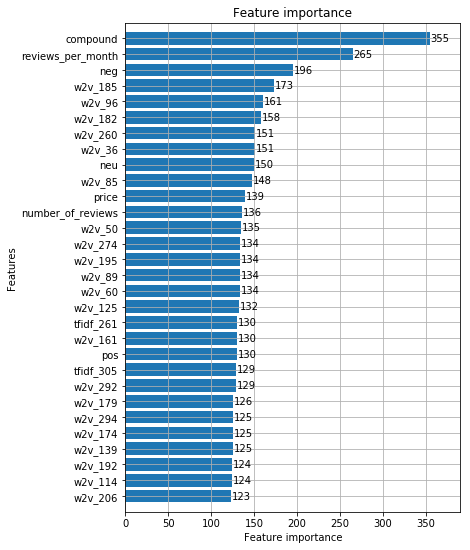

In [76]:
fig, ax = plt.subplots(figsize=(6,9))
lgb.plot_importance(gbm, max_num_features=30, height=0.8, ax=ax)
plt.show()

In [37]:
lgb_preds = gbm.predict(test_sent_w2v_300_tfidf_500[predictors])

In [14]:
test_sent_w2v_300_tfidf_500.shape

(41144, 822)

In [15]:
test_sent_w2v_300_tfidf_500['listing_id'].nunique()

41129

In [17]:
test_sent_w2v_300_tfidf_500['listing_id'].loc[test_sent_w2v_300_tfidf_500.duplicated('listing_id') == True]

14331    8222951
14332    8222951
14333    8222951
14334    8222951
14335    8222951
14336    8222951
14337    8222951
14338    8222951
14339    8222951
14340    8222951
14341    8222951
14342    8222951
14343    8222951
14344    8222951
14345    8222951
Name: listing_id, dtype: int64

In [19]:
lgb_preds.size

41144

In [21]:
test_sent_w2v_300_tfidf_500['review_scores_rating'] = lgb_preds

In [23]:
test_sent_w2v_300_tfidf_500.drop_duplicates('listing_id', inplace=True)

In [24]:
test_sent_w2v_300_tfidf_500.shape

(41129, 823)

In [19]:
submit = pd.read_csv('submit.csv', header=None)#, usecols=['listing_id', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'])
submit[1] = full_pred# + lgb_preds)/2.0#test_sent_w2v_300_tfidf_500['review_scores_rating']
submit[1].loc[submit[1]>100] = 100
submit[2].loc[submit[2]>10] = 10
submit[3].loc[submit[3]>10] = 10
submit[4].loc[submit[4]>10] = 10
submit[5].loc[submit[5]>10] = 10
submit[6].loc[submit[6]>10] = 10
submit[7].loc[submit[7]>10] = 10
submit.to_csv('submit.csv', index=False, header=False)

C:\Users\I345351\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
